[<center>![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</center>](https://colab.research.google.com/drive/1sUgL_vsOaE2ZltgDg0gcEK-LZU-oadVm?usp=sharing)

[Meta: Data - Competencia en ciencia de Datos](https://metadata.fundacionsadosky.org.ar/competition/22/)

# Clasificación de cultivos utilizando imágenes satelitales

## Introducción

Este notebook aborda el trabajo desarrollado en el desafío AgTech 2020 para categorizar cultivos en imágenes obtenidas de los satélites Landsat 8, Sentinel 1 y Sentinel 2 a través de la API Google Earth Engine. Describe las etapas seguidas y las decisiones que se tomaron hasta la construcción de un modelo de clasificación multiclase mediante un algoritmo de Gradient Boosting utilizando el framework Lightgbm.

## 1. Setup
### 1.1. Librerías

In [1]:
import os
import math
import shapefile
import folium
import ee
import pandas as pd
import numpy as np
import shap
import lightgbm as lgb
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

### 1.2. Directorios

In [2]:
# Directorio raíz
rdir = os.path.abspath("__file__" + "/../../")

# Subdirectorios
DATA_RAW = os.path.join(rdir, "data/")
MODEL_INPUT = os.path.join(rdir, "data/")
MODEL_OUTPUT = os.path.join(rdir, "data/output/")
SUBMIT = os.path.join(rdir, "data/output/")

# Nombres de los archivos a cargar
AOI = "aoi/Gral Lopez.shp"
TRAIN = "data_train.csv"
TEST = "data_test.csv"
TEST_SOLUCION = "data_test_solucion.csv"
ETIQUETAS = "etiquetas.csv"

### 1.3. Inicialización de Earth Engine 

In [3]:
# Autenticación
# auth.authenticate_user()

# Conexión
ee.Initialize()

## 2. Datos

### 2.1. Área de interés
Se visualiza en un mapa la superficie que contiene las observaciones de verdad de campo entregadas para entrenar y evaluar el modelo.

In [4]:
# Se carga la geometría de la zona en estudio (General López)
aoi_shp = shapefile.Reader((os.path.join(rdir, DATA_RAW, AOI)))

# Se recuperan las coordenadas del polígono que forma la zona en estudio
feature = aoi_shp.shapeRecords()[0]
aoi_geometry = feature.shape.__geo_interface__

aoi_geometry["coordinates"][0][1:10]

[(-61.51664980800001, -33.407502609999995),
 (-61.47422924, -33.46268346900001),
 (-61.474185463000026, -33.46274042099998),
 (-61.46829425300001, -33.47037071699998),
 (-61.456758224, -33.46415670099998),
 (-61.440239899999995, -33.45525529399998),
 (-61.422240801999976, -33.44555151499998),
 (-61.416323250999994, -33.453152848),
 (-61.411494613, -33.45928174199997)]

In [5]:
# Se establece una geometría Earth Engine
ee_aoi_geometry = ee.Geometry.Polygon(aoi_geometry["coordinates"])

In [6]:
def Mapdisplay(center, dicc, Tiles="OpensTreetMap", zoom_start=10):
    """
    Retorna un objeto folium.Map para visualizar el mapa de una región definida con los parámetros 
    'center' y 'dicc'.

    :param center: Centro del área del mapa a visualizar.
    :param dicc: Geometría Earth Engine.
    :param Tiles: Tipo de mosaico (Mapbox Bright, Mapbox Control Room, Stamen Terrain,
     stamenwatercolor, cartodbpositron).
    :param zoom_start: Nivel de zoom inicial para el mapa.

    """
    mapViz = folium.Map(location=center, tiles=Tiles, zoom_start=zoom_start)

    for k, v in dicc.items():
        if ee.image.Image in [type(x) for x in v.values()]:
            folium.TileLayer(
                tiles=v["tile_fetcher"].url_format,
                attr="Google Earth Engine",
                overlay=True,
                name=k,
            ).add_to(mapViz)
    else:
        folium.GeoJson(data=v, name=k).add_to(mapViz)

    mapViz.add_child(folium.LayerControl())

    return mapViz

In [7]:
# Centro del área de interés (General López)
center = ee_aoi_geometry.centroid().getInfo()["coordinates"]
center.reverse()

# Geometría de la zona
dicc_aio = {"General López": ee_aoi_geometry.getInfo()}

# Visualización en el mapa del área de interés
Mapdisplay(center, dicc_aio, zoom_start=9)

### 2.2. Datos de Trabajo
Se cargan los datos de trabajo y se renombran los nombres de las columnas.

In [8]:
# Se cargan los datasets correspondientes
df_train = pd.read_csv(os.path.join(DATA_RAW, TRAIN))
df_test = pd.read_csv(os.path.join(DATA_RAW, TEST))
df_etiquetas = pd.read_csv(os.path.join(DATA_RAW, ETIQUETAS))

# Se pasan a minúscula todos los nombres de las columnas
df_train.columns = [x.lower() for x in df_train.columns]
df_test.columns = [x.lower() for x in df_test.columns]
df_etiquetas.columns = [x.lower() for x in df_etiquetas.columns]

# Se renombran 'Longitud' y 'Latitud'
df_train.rename(columns={"longitud": "longitude", "latitud": "latitude"}, inplace=True)
df_test.rename(columns={"longitud": "longitude", "latitud": "latitude"}, inplace=True)

print(f"Número de registros para entrenar: {df_train.shape[0]}")
print(f"Número de registros a predecir clase: {df_test.shape[0]}")

Número de registros para entrenar: 850
Número de registros a predecir clase: 555


In [9]:
# Cantidad de categorías disponibles por clase de cultivo (verdad de campo)
df_train["cultivo"].value_counts()

S      344
M      210
s       89
N       82
P       55
X       34
U       12
B        6
R        6
m        4
A        2
aa       2
T        2
G        1
S/M      1
Name: cultivo, dtype: int64

Se aprecia una diferencia importante en el número de observaciones por categoría.

### 2.3. Tratamiento de datos
En el punto anterior se observa un registro con la identificación 'S/M' el cual no pertenece a ninguna de las clases a predecir. En realidad, parece indicar que el cultivo corresponde a soja tipo 1 o maíz temprano. Dada la cantidad de registros con estas características se decide prescindir del mismo.

In [10]:
df_train[df_train["cultivo"] == "S/M"]

,id,cultivo,longitude,latitude,elevacion,dataset,campania,globalid
150,278,S/M,-62.032337,-33.572599,109.66362,BC,18/19,278


In [11]:
# Se elimina el registro
df_train = df_train[df_train["globalid"] != 278]

Se verifica que hay coordenadas duplicadas en la base de entrenamiento. Como criterio se adopta eliminar ambos registros.

In [12]:
# Se evalúa si hay coordenadas duplicadas y se muestra el resultado
df_train.loc[df_train[["longitude", "latitude"]].duplicated(), ["longitude", "latitude"]]

,longitude,latitude
132,-62.010454,-33.783648


In [13]:
# Se recuperan los registros repetidos
df_train[df_train["longitude"] == -62.010454]

,id,cultivo,longitude,latitude,elevacion,dataset,campania,globalid
131,227,X,-62.010454,-33.783648,95.07975,BC,18/19,227
132,228,S,-62.010454,-33.783648,95.07975,BC,18/19,228


In [14]:
# Se eliminan del dataset ambos registros
df_train = df_train[(df_train["globalid"] != 228) & (df_train["globalid"] != 227)]

Se transforma la columna `cultivo` en un variable numérica.

In [15]:
# Diccionario con valores numéricos para cada cultivo
cultivo_num = {
    "S": 0,
    "M": 1,
    "U": 2,
    "B": 3,
    "R": 4,
    "s": 5,
    "N": 6,
    "m": 7,
    "P": 8,
    "A": 9,
    "X": 10,
    "T": 11,
    "G": 12,
    "aa": 13,
}

# Remapeo de los id de los cultivos
df_train = df_train.replace({"cultivo": cultivo_num})

In [16]:
df_train.head()

,id,cultivo,longitude,latitude,elevacion,dataset,campania,globalid
0,1,0,-62.144163,-33.800202,104.111862,BC,18/19,1
1,4,1,-62.155418,-33.801742,105.698082,BC,18/19,4
2,6,6,-62.163615,-33.808092,104.233162,BC,18/19,6
3,7,1,-62.164773,-33.813671,103.859932,BC,18/19,7
4,9,1,-62.097200,-33.778628,98.532104,BC,18/19,9


### 2.4. Generación de nuevos datos

En el dataset de entrenamiento hay 14 tipos de cultivos, el cual se encuentra desbalanceado ya que unas pocas clases representan la mayor parte del conjunto de datos. **Para complementar la información dada se generan nuevos 'puntos' vecinos de cultivo a partir de las coordenadas de los registros de las categorías minoritarias**.

Por cada 'punto' elegido se crean 8 nuevos a 30 y 60 m (1 *arriba*, 1 *abajo*, 1 a la *izquierda*, 1 a la *derecha* y 4 en *diagonal*). Como criterio, el aumento de datos se aplica sobre los cultivos 'G', 'aa', 'T', 'A', 'm', 'R', 'B' y 'U'.

**Este procedimiento podría generar un mal entrenamiento del modelo si éste interpreta que la clasificación de algunos puntos se define a partir de la cercanía entre ellos**, por este motivo más adelante se eliminan las variables `longitude`, `latitude` y `elevacion` para no sesgar las predicciones con la posición de las observaciones de verdad de campo en el área estudiada.

In [17]:
# Se seleccionan los puntos sobre los cuales se van a generar nuevos registros
df_expand = df_train[
    (df_train["cultivo"] == 12)
    | (df_train["cultivo"] == 13)
    | (df_train["cultivo"] == 11)
    | (df_train["cultivo"] == 9)
    | (df_train["cultivo"] == 7)
    | (df_train["cultivo"] == 4)
    | (df_train["cultivo"] == 3)
    | (df_train["cultivo"] == 2)
]
df_expand.head()

,id,cultivo,longitude,latitude,elevacion,dataset,campania,globalid
12,28,9,-62.177278,-33.814441,103.561348,BC,18/19,28
60,109,4,-62.177417,-33.866643,111.688385,BC,18/19,109
114,201,13,-62.007558,-33.630192,119.367538,BC,18/19,201
116,203,13,-62.009457,-33.627223,121.615204,BC,18/19,203
133,233,4,-62.016011,-33.806956,103.878593,BC,18/19,233


In [18]:
def delta_coord(df, dkm, r_earth):
    """
    Retorna un dataframe con 8 puntos (definidos por las variables 'longitude' y 'latitude')
    ubicados a una distancia dada en km ('dkm').

    Cada nuevo punto mantiene la misma información (verdad de campo) del punto padre original.

    :param df: Dataframe con los puntos padre a aumentar.
    :param dkm: Distancia en km entre los nuevos puntos vecinos generados y el punto padre.
    :param r_earth: Radio de la tierra en km.

    """

    # Copia el registro (punto padre) 8 veces como dataframe
    df_expand = df.append([df] * 7, ignore_index=True)

    # Valores de longitud y latitud del punto padre
    latitude = df["latitude"].values
    longitude = df["longitude"].values

    # Delta longitud y latitud (distancia del nuevo punto al padre)
    dlat = (dkm / r_earth) * (180 / math.pi)
    dlon = (dkm / r_earth) * (180 / math.pi) / math.cos(latitude * math.pi / 180)

    # Longitud y latitud de cada nuevo punto
    ## Punto 1
    df_expand.iloc[0:1, 3] = latitude
    df_expand.iloc[0:1, 2] = longitude + dlon
    ## Punto 2
    df_expand.iloc[1:2, 3] = latitude
    df_expand.iloc[1:2, 2] = longitude - dlon
    ## Punto 3
    df_expand.iloc[2:3, 3] = latitude + dlat
    df_expand.iloc[2:3, 2] = longitude
    ## Punto 4
    df_expand.iloc[3:4, 3] = latitude - dlat
    df_expand.iloc[3:4, 2] = longitude
    ## Punto 5
    df_expand.iloc[4:5, 3] = latitude + dlat
    df_expand.iloc[4:5, 2] = longitude + dlon
    ## Punto 6
    df_expand.iloc[5:6, 3] = latitude - dlat
    df_expand.iloc[5:6, 2] = longitude + dlon
    ## Punto 7
    df_expand.iloc[6:7, 3] = latitude - dlat
    df_expand.iloc[6:7, 2] = longitude - dlon
    ## Punto 8
    df_expand.iloc[7:8, 3] = latitude + dlat
    df_expand.iloc[7:8, 2] = longitude - dlon

    return df_expand

In [19]:
# Para cada registro dado (cultivo minoritario) se generan 8 nuevos puntos en un radio de 30 m 
# y se guardan en una lista
list_new_coord_30 = [
    delta_coord(df_expand.iloc[i : (i + 1), :], 0.03, 6378) for i in range(len(df_expand))
]

# Se generan 8 nuevos puntos a 60 m y se guardan en una lista
list_new_coord_60 = [
    delta_coord(df_expand.iloc[i : (i + 1), :], 0.06, 6378) for i in range(len(df_expand))
]

# Se concatenan los resultados de las listas para generar un dataframe con los nuevos datos
df_new_coord_30 = pd.concat(list_new_coord_30, ignore_index=True)
df_new_coord_60 = pd.concat(list_new_coord_60, ignore_index=True)

df_new_coord_30.head()

,id,cultivo,longitude,latitude,elevacion,dataset,campania,globalid
0,28,9,-62.176954,-33.814441,103.561348,BC,18/19,28
1,28,9,-62.177603,-33.814441,103.561348,BC,18/19,28
2,28,9,-62.177278,-33.814172,103.561348,BC,18/19,28
3,28,9,-62.177278,-33.814711,103.561348,BC,18/19,28
4,28,9,-62.176954,-33.814172,103.561348,BC,18/19,28


In [20]:
print(f"Cantidad de puntos nuevos vecinos a 30 m: {df_new_coord_30.shape[0]}")
print(f"Cantidad de puntos nuevos vecinos a 60 m: {df_new_coord_60.shape[0]}")

Cantidad de puntos nuevos vecinos a 30 m: 280
Cantidad de puntos nuevos vecinos a 60 m: 280


In [21]:
# Dato de inetrés
df_train.globalid.max()

1455

Cada punto nuevo generado debe tener un identificador único, por eso se les asigna un `globalid` diferente.

In [22]:
# Se cambia el 'globalid' de los puntos nuevos
# Máximo 'globalid' existente 1455
df_new_coord_30["globalid"] = list(range(1456, len(df_new_coord_30) + 1456))
df_new_coord_60["globalid"] = list(range(1736, len(df_new_coord_60) + 1736))

# Se agregan los nuevos puntos a la base de entrenamiento
df_train = pd.concat([df_train, df_new_coord_30, df_new_coord_60])

print(f"Cantidad de registros en el conjunto de entrenamiento: {df_train.shape[0]}")

Cantidad de registros en el conjunto de entrenamiento: 1407


In [23]:
# Cantidad de registros por categoría de cultivo
df_train.cultivo.value_counts()

0     343
1     210
2     204
4     102
3     102
5      89
6      82
7      68
8      55
13     34
11     34
9      34
10     33
12     17
Name: cultivo, dtype: int64

Se aprecia ahora que, por ejemplo, hay 16 nuevos registros con información del cultivo Girasol. **Algunas de las clases minoritarias pasan a tener más registros que otros cultivos a los que no se aplicó la aumentación de puntos**. Se acepta lo anterior y se sigue adelante.

Se grafican los nuevos puntos generados para la categoría Girasol en un mapa con imágenes del satélite *Sentinel 2*.

In [24]:
def df2geojson(df):
    """
    Retorna un objeto geojson generado a partir de un dataframe ('df').

    :param df: Dataframe a convertir en formato geojson.

    """
    # Se crea un objeto geojson vacío
    geojson = {"type": "FeatureCollection", "features": []}

    # Se itera por cada fila del dataframe para armar el diccionario
    for _, row in df.iterrows():
        feature = {
            "type": "Feature",
            "geometry": {"type": "Point", "coordinates": [row["longitude"], row["latitude"]]},
            "properties": {
                "campania": row["campania"],
                "filter": row["filter"] if "filter" in df.columns else None,
            },
        }
        geojson["features"].append(feature)

    return geojson

In [25]:
# Se seleccionan los nuevos datos generados para el cultivo Girasol
girasol_vecinos = df_train[(df_train["globalid"] > 443) & (df_train["cultivo"] == 12)]

# Se selecciona el registro original de Girasol
girasol_padre = df_train[df_train["globalid"] == 443]

# Se crea una colección Earth Engine
ee_girasol_vecinos = ee.FeatureCollection(df2geojson(girasol_vecinos))
ee_girasol_padre = ee.FeatureCollection(df2geojson(girasol_padre))

# Se descargan imágenes de Sentinel 2 para visualizar
s2 = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterDate("2020-01-01", "2020-10-31")
    .median()
    .clip(ee_aoi_geometry)
    .multiply(0.0001)
)

# Se seleccionan las bandas de interés
RGB_bands = ["B4", "B3", "B2"]
s2_rgb = s2.select(RGB_bands)

visParams_s2 = {
    "bands": ["B4", "B3", "B2"],
    "min": 0,
    "max": 0.5,
    "gamma": 1.4,
}

s2Mapid = s2.getMapId(visParams_s2)

# Centro del área de ineterés
center = ee_girasol_padre.geometry().centroid().getInfo()["coordinates"]
center.reverse()

# 'Punto' Girasol padre en rojo y nuevos puntos vecinos en amarillo
dicc = {
    "satelite": s2Mapid,
    "pts_vecinos": ee_girasol_vecinos.draw(**{"color": "yellow", "strokeWidth": 3}).getMapId(),
    "pts_padre": ee_girasol_padre.draw(**{"color": "red", "strokeWidth": 3}).getMapId(),
    "GeneralLopez": ee_aoi_geometry.getInfo(),
}

# Se genera la visualización del mapa
Mapdisplay(center, dicc, zoom_start=16.5)

Se observan los nuevos puntos vecinos generados en el mapa (color amarillo) a partir del único registro disponible del cultivo Girasol (color rojo). Parece que uno de los puntos se encuentra muy cerca de otro cultivo. **Efectivamente, algunos de los registros nuevos creados no representan el cultivo padre ya que 'caen' dentro de otro tipo de superficie**. De todas formas, se considera que el beneficio de aumentar los datos es mejor que no hacerlo.

A continuación, se visualizan todos los puntos de train y test en el área de estudio (General López). Primero, se unen los registros en un solo conjunto de datos.

In [26]:
# Se agrega un identificador a los datos de train y test
df_train["filter"] = 0
df_test["filter"] = 1

# Se unen train y test
dataset = pd.concat([df_train, df_test], axis=0)
dataset.shape

(1962, 9)

In [27]:
# Se crea una colección Earth Engine con todos los datos
dataset_collection = ee.FeatureCollection(df2geojson(dataset))

# Se diferencian los puntos de entrenamiento y test
fe_train = dataset_collection.filter(ee.Filter.eq("filter", 0))
fe_test = dataset_collection.filter(ee.Filter.eq("filter", 1))

# Centro del área de interés
center = dataset_collection.geometry().centroid().getInfo()["coordinates"]
center.reverse()

# Propiedades y geometría de los puntos
dicc = {
    "train": fe_train.draw(**{"color": "red", "strokeWidth": 5}).getMapId(),
    "test": fe_test.draw(**{"color": "blue", "strokeWidth": 5}).getMapId(),
    "GeneralLopez": ee_aoi_geometry.getInfo(),
}

# Visualización del mapa
Mapdisplay(center, dicc, zoom_start=9.5)

En el mapa se muestran los puntos registrados de verdad de campo para el conjunto de entrenamiento (color rojo) y para el conjunto de testeo (color azul).

## 3. Obtención de imágenes satelitales

Se obtienen las imágenes satelitales a través del método `.getInfo()` de [Google Earth Engine](https://earthengine.google.com/). El objetivo es poder descargar todas las imágenes disponibles en cada satélite en el intervalo de tiempo indicado. Luego, en forma local se realizan todas las operaciones deseadas (reducción, ingeniería de características, etc.).

En este trabajo se utilizan imágenes de los satélites *Landsat 8*, *Sentinel 1* y *Sentinel 2* con dos niveles de corrección:
- USGS Landsat 8 Surface Reflectance Tier 1.
- Sentinel-1 SAR GRD: C-band Synthetic Aperture Radar Ground Range Detected, log scaling.
- Sentinel-2 MSI: MultiSpectral Instrument, Level-2A.
- Sentinel-2 MSI: MultiSpectral Instrument, Level-1C.

Todas las propiedades de las imágenes que se solicitan a *GEE* (tipo de satélite, escala de las imágenes, etc.) se ordenan en un único diccionario. 

In [28]:
# Diccionario con propiedades de cada satélite de interés
satellite = {
    "l8": {
        "img_collection": "LANDSAT/LC08/C01/T1_SR",
        "scale": 30,
        "bands": ["B1", "B3", "B4", "B5", "B7", "B11", "pixel_qa"],
        "prop_cloud": "CLOUD_COVER",
        "porc_cloud": 30,
        "maskS2clouds": {"qa": "pixel_qa", "cloudsBit": 5, "cloudShadowBit": 3},
    },
    "s1": {
        "img_collection": "COPERNICUS/S1_GRD",
        "scale": 10,
        "bands": None,
        "prop_cloud": None,
        "porc_cloud": None,
        "maskS2clouds": None,
    },
    "s2-l1c": {
        "img_collection": "COPERNICUS/S2",
        "scale": 10,
        "bands": ["B1", "B3", "B4", "B5", "B7", "B8", "B9", "B11", "B12", "QA60"],
        "prop_cloud": "CLOUDY_PIXEL_PERCENTAGE",
        "porc_cloud": 10,
        "maskS2clouds": {"qa": "QA60", "cloudsBit": 10, "cloudCirrusBit": 11},
    },
    "s2-l2a": {
        "img_collection": "COPERNICUS/S2_SR",
        "scale": 10,
        "bands": ["B1", "B3", "B4", "B5", "B7", "B8", "B9", "B11", "B12", "QA60"],
        "prop_cloud": "CLOUDY_PIXEL_PERCENTAGE",
        "porc_cloud": 10,
        "maskS2clouds": {"qa": "QA60", "cloudsBit": 10, "cloudCirrusBit": 11},
    },
}

**Se crea una clase que realiza las solicitudes a la plataforma de Google y convierte los datos descargados en un dataframe de [Pandas](https://pandas.pydata.org/), el cual se adhiere a los conjuntos de entrenamiento y testeo (**`dataset`**) con información de la verdad de campo**.

Para no exceder el límite permitido de consulta de *GEE* algunas solicitudes se dividen en sub-intervalos de tiempo.

In [29]:
class GetDfImages:

    """
    Retorna un dataframe con datos de imágenes satelitales descargados desde Earth Engine.
    La información descargada se agrega al dataset que contiene los datos de verdad de campo.
    Las imágenes con nubes devuelven valores nulos aplicando funciones de enmascaramiento.
    """

    def __init__(
        self, df=None, start=None, end=None, collection=None, campania_col=None, campania_date=None
    ):
        """
        Parámetros.

        :param df: Dataframe con datos de verdad de campo.
        :param start: Fecha de inicio a partir de la que se descargan imágenes.
        :param end: Última fecha de descarga de imágenes.
        :param collection: Objeto FeatureCollection de Earth Engine que define las imágenes a 
         descargar.
        :param campania_col: Nombre de la columna que identifica la campaña de interés.
        :param campania_date: Dato con referencia a la fecha de campaña.

        """

        self.df = df
        self.start = start
        self.end = end
        self.collection = collection
        self.campania_col = campania_col
        self.campania_date = campania_date

    def __maskS2clouds(self, image, prop_mask):

        """
        Función para enmascarar nubes usando las bandas de control de calidad Sentinel-2 o 
        Landsat-8.

        :param image: Imagen a enmascarar.
        :param prop_mask: Propiedad de imagen que se utiliza para enmascarar.

        """

        # Banda QA
        qa = image.select(prop_mask["qa"])

        # Bits de nubes
        cloudsBitMask = 1 << prop_mask["cloudsBit"]

        # Enmascaramiento
        mask = qa.bitwiseAnd(cloudsBitMask).eq(0)

        if "cloudShadowBit" in prop_mask.keys():
            # Landsat 8 - Bitmask para pixel_qa 
            cloudShadowBitMask = 1 << prop_mask["cloudShadowBit"]
            # Ambos indicadores deben ponerse a cero, lo que indica condiciones claras.
            mask = mask.bitwiseAnd(cloudShadowBitMask).eq(0)

        else:
            # Sentinel 2 - Bitmask para QA60
            cloudCirrusBitMask = 1 << prop_mask["cloudCirrusBit"]
            # Ambos indicadores deben ponerse a cero, lo que indica condiciones claras.
            mask = mask.bitwiseAnd(cloudCirrusBitMask).eq(0)

        return image.updateMask(mask)

    def __get_data(self, images, scale=30):

        """
        Descarga desde Earth Engine los datos de las imágenes requeridos.

        :param images: Objeto ImageCollection GEE.
        :param scale: Escala del pixel a descargar.

        """
        # Si se define una campaña se recuperan sólo los datos para la misma
        if self.campania_col:
            return images.getRegion(
                self.collection.filter(ee.Filter.eq(self.campania_col, self.campania_date)),
                scale=scale,
            ).getInfo()

        # Si no se especifica una campaña se descargan todos los datos de la colección
        else:
            return images.getRegion(self.collection, scale=scale).getInfo()

    def __to_df(self, images_data):

        """
        Convierte los datos descargados en un dataframe y los agrega la base de verdad de campo.

        Hay una leve diferencia entre las coordenadas entregadas para descargar las imágenes y las 
        devueltas por Engine Earth en sus metadatos. Para poder vincular la información solicitada 
        (en formato dataframe) con el conjunto de verdad de campo simplemente se ordenan las filas 
        de ambos datasets por sus coordenadas y se unen en dicho orden.

        :param images_data: Información descargada de las imágenes.

        """

        # Se convierten los datos descargados en un dataframe
        df_data = pd.DataFrame(images_data[1:])
        df_data.columns = images_data[0]

        # Se elimina lo que no se necesita
        df_data = df_data.drop(["id"], axis=1)

        # Se recuperan las coordenadas devueltas por GEE en los metadatos
        # Estas coordenadas difieren levemente de las coordenadas de verdad de campo
        coord = df_data[["longitude", "latitude"]].drop_duplicates()
        coord = coord.sort_values(["longitude", "latitude"])

        # Es importante que el conjunto de verdad de campo tenga las columnas con los
        # nombres 'longitude' y 'latitude' sino se genera un error
        try:
            # Cuando se trabaja con una campaña específica se filtran los datos
            if self.campania_col:
                df_verdad_campo = self.df[self.df[self.campania_col] == self.campania_date]
            # O bien se usa todo el conjunto de datos
            else:
                df_verdad_campo = self.df

            # Se ordena el dataset de verdad de campo por 'longitude' y 'latitude'
            df_verdad_campo = df_verdad_campo.sort_values(["longitude", "latitude"])
            df_verdad_campo = df_verdad_campo.drop(["longitude", "latitude"], axis=1)

            # Se vinculan los datos de verdad de campo con las coordenadas devueltas por GEE
            df_c = pd.concat(
                [coord.reset_index(drop=True), df_verdad_campo.reset_index(drop=True)], axis=1
            )

        except:
            print("Nombre de columna inválido")

        # Join de los datos descargados de las imágenes con el dateset de verdad de campo
        # mediante las variables 'longitude' y 'latitude' (coordenadas devueltas por GEE)
        df_data = pd.merge(df_data, df_c, on=["longitude", "latitude"])

        return df_data

    def get_satellite_data(self, satellite):

        """
        Retorna un Pandas dataframe con los datos de verdad de campo y las bandas de las imágenes 
        descargadas.

        :param satellite: Satélite usado para descargar las imágenes desde Earth Engine.

        """

        # Características y propiedades de las imágenes solicitadas
        img_collection = satellite["img_collection"]
        scale = satellite["scale"]
        bands = satellite["bands"]
        prop_cloud = satellite["prop_cloud"]
        porc_cloud = satellite["porc_cloud"]
        prop_mask = satellite["maskS2clouds"]

        # Objeto Earth Engine con información de la colección de imágenes
        images = (
            ee.ImageCollection(img_collection)
            .filterBounds(self.collection)
            .filterDate(self.start, self.end)
        )

        # Si se especifican las bandas a descargar
        if bands:
            images = images.select(bands)

        # Se enmascaran las imágenes con nubes
        if prop_cloud:
            images = images.filter(ee.Filter.lt(prop_cloud, porc_cloud))
            images = images.map(lambda image: self.__maskS2clouds(image, prop_mask))

        # Se recupera desde Earth Engine la información requerida
        get_images_data = self.__get_data(images=images, scale=scale)

        # Se transforma en dataframe y se agrega a la verdad de campo
        df_data = self.__to_df(images_data=get_images_data)

        return df_data

Se descargan las imágenes de las campañas estableciendo los siguientes períodos:

- 18/19: septiembre 2018 a agosto 2019 
- 19/20: septiembre 2019 a agosto 2020

**Por el momento se adopta septiembre como fecha general de referencia de inicio para la siembra de los cultivos de cada campaña y no se hace ninguna inferencia respecto al momento de cosecha, valores de los indicadores ambientales, etc**.

Las imágenes de los satélites se descargan separadas por campaña. Debido a que *S2* aporta más información las consultas a *GEE* para la campaña 19/20 se dividen en subintervalos de tiempo con el fin de no exceder los límites establecidos en la plataforma. Otra alternativa, se puede armar una configuración unificada de ventanas de tiempo entre el período 09/18-08/20 y descargar todas las campañas juntas para cada satélite.

In [30]:
# Objeto para compaña 18/19
campania_1819 = GetDfImages(
    df=dataset,
    start="2018-09-01",
    end="2019-08-31",
    collection=dataset_collection,
    campania_col="campania",
    campania_date="18/19",
)

# Objeto para campaña 19/20
campania_1920 = GetDfImages(
    df=dataset,
    start="2019-09-01",
    end="2020-08-31",
    collection=dataset_collection,
    campania_col="campania",
    campania_date="19/20",
)

# Objeto para campaña 19/20 sin ventanas de tiempo definida
campania_1920_na = GetDfImages(
    df=dataset,
    start=None,
    end=None,
    collection=dataset_collection,
    campania_col="campania",
    campania_date="19/20",
)

In [31]:
def get_df_images_by_interval(campania, start, end, satelite):

    """
    Retorna un Pandas dataframe con los datos de verdad de campo y las bandas de las imágenes 
    descargadas en un intervalo de tiempo definido.

    :param campania: Objeto (instancia) con la campaña solicitada.
    :param start: Fecha de inicio de descarga de imágenes.
    :param end: Fecha última de descarga de imágenes.
    :param satelite: Satélite usado para descargar las imágenes desde Earth Engine.

    """

    campania.start = start
    campania.end = end

    df_tmp = campania.get_satellite_data(satelite)

    return df_tmp

Se comienzan a descargar las imágenes satelitales.

In [32]:
%%time

# Satélite Lansdat l8
## Campaña 18/19
df_l8_1819 = campania_1819.get_satellite_data(satellite["l8"])
print('Completo Satélite L8 - Campaña 18-19 ...')

## Campaña 19/20
df_l8_1920 = campania_1920.get_satellite_data(satellite["l8"])
print('Completo Satélite L8 - Campaña 19-20 ...')

# Satélite Lansdat s1
## Campaña 18/19
df_s1_1819 = campania_1819.get_satellite_data(satellite["s1"])
print('Completo Satélite S1 - Campaña 18-19 ...')

## Campaña 19/20
df_s1_1920 = campania_1920.get_satellite_data(satellite["s1"])
print('Completo Satélite S1 - Campaña 19-20 ...')

# Intervalos de tiempo de descarga
## El objetivo es obtener los datos desde 2019-09-01 a 2020-08-31
## Para no exceder el límite de consulta permitido en GEE se discretiza en sub-intervalos
time_intervals = {
    "t1": ["2019-09-01", "2019-11-30"],
    "t2": ["2019-12-01", "2020-02-29"],
    "t3": ["2020-03-01", "2020-05-30"],
    "t4": ["2020-06-01", "2020-08-31"],
}

# Satélite Lansdat s2-l1C
## Campaña 18/19
df_s2l1c_1819 = campania_1819.get_satellite_data(satellite["s2-l1c"])
print('Completo Satélite S2-l21C - Campaña 18-19 ...')

## Campaña 19/20
### Se descarga cada intervalo en una lista
lst_df_s2l1c_1920 = [
    get_df_images_by_interval(campania_1920_na, t[1][0], t[1][1], satellite["s2-l1c"])
    for t in time_intervals.items()
]

### Se concatena la lista en un df
df_s2l1c_1920 = pd.concat(lst_df_s2l1c_1920, ignore_index=True)
print('Completo Satélite S2-l21C - Campaña 19-20 ...')

# Satélite Lansdat s2-l2A
## Campaña 18/19
df_s2l2a_1819 = campania_1819.get_satellite_data(satellite["s2-l2a"])
print('Completo Satélite S2-l21A - Campaña 18-19 ...')

## Campaña 19/20
lst_df_s2l2a_1920 = [
    get_df_images_by_interval(campania_1920_na, t[1][0], t[1][1], satellite["s2-l2a"])
    for t in time_intervals.items()
]

### Se concatena la lista en un df
df_s2l2a_1920 = pd.concat(lst_df_s2l2a_1920, ignore_index=True)
print('Completo Satélite S2-l21A - Campaña 19-20')

Completo Satélite L8 - Campaña 18-19 ...
Completo Satélite L8 - Campaña 19-20 ...
Completo Satélite S1 - Campaña 18-19 ...
Completo Satélite S1 - Campaña 19-20 ...
Completo Satélite S2-l21C - Campaña 18-19 ...
Completo Satélite S2-l21C - Campaña 19-20 ...
Completo Satélite S2-l21A - Campaña 18-19 ...
Completo Satélite S2-l21A - Campaña 19-20
Wall time: 3min 54s


In [33]:
#  Vista dataframe con datos Sentinel 1
df_s1_1819.head()

,longitude,latitude,time,VV,VH,angle,id,cultivo,elevacion,dataset,campania,globalid,filter
0,-61.384713,-33.637551,1536225734000,-16.891659,-24.834885,37.794636,486,NaN,87.885788,BC,18/19,486,1
1,-61.384713,-33.637551,1537262535000,-16.795192,-22.706080,37.792187,486,NaN,87.885788,BC,18/19,486,1
2,-61.384713,-33.637551,1538299335000,-15.746004,-21.976511,37.792393,486,NaN,87.885788,BC,18/19,486,1
3,-61.384713,-33.637551,1539336135000,-16.216816,-20.911749,37.792076,486,NaN,87.885788,BC,18/19,486,1
4,-61.384713,-33.637551,1540372935000,-9.551963,-21.142338,37.796970,486,NaN,87.885788,BC,18/19,486,1


In [34]:
# Vista dataframe con datos Sentinel 2-l2A
df_s2l2a_1920.iloc[0:5, 0:15]

,longitude,latitude,time,B1,B3,B4,B5,B7,B8,B9,B11,B12,QA60,id,cultivo
0,-62.68736,-34.272929,1567606328611,560.0,975.0,1382.0,1667.0,2152.0,2336.0,2452.0,3242.0,2127.0,0.0,266,6.0
1,-62.68736,-34.272929,1568298125113,234.0,674.0,995.0,1296.0,1623.0,1794.0,1977.0,2537.0,1670.0,0.0,266,6.0
2,-62.68736,-34.272929,1568470327636,448.0,875.0,1266.0,1589.0,1966.0,2084.0,2285.0,3266.0,2148.0,0.0,266,6.0
3,-62.68736,-34.272929,1568730123870,401.0,835.0,1150.0,1393.0,1773.0,1996.0,2125.0,3051.0,1964.0,0.0,266,6.0
4,-62.68736,-34.272929,1569162123961,469.0,898.0,1208.0,1489.0,1905.0,2116.0,2246.0,3055.0,2049.0,0.0,266,6.0


Por ahora se tienen los datos descargados de cada satélite y cada campaña por separado; en lo que sigue se juntan. Los datos enmascarados (imágenes con nubes) aparecen como registros de valores nulos en cada dataframe los cuales se eliminan.

In [35]:
# Se juntan las campañas de cada satélite
df_l8 = df_l8_1819.append(df_l8_1920)
df_s1 = df_s1_1819.append(df_s1_1920)
df_s2l1c = df_s2l1c_1819.append(df_s2l1c_1920)
df_s2l2a = df_s2l2a_1819.append(df_s2l2a_1920)

# Se elimina lo que no se necesita
df_l8 = df_l8.drop(["id", "dataset"], axis=1)
df_s1 = df_s1.drop(["id", "dataset"], axis=1)
df_s2l1c = df_s2l1c.drop(["id", "dataset"], axis=1)
df_s2l2a = df_s2l2a.drop(["id", "dataset"], axis=1)

# Se eliminan las filas que tienen valores nulos en las bandas (solo las que fueron filtrados por cloud)
df_l8 = df_l8[df_l8["B4"].notna()]
df_s1 = df_s1[df_s1["VV"].notna()]
df_s2l1c = df_s2l1c[df_s2l1c["B8"].notna()]
df_s2l2a = df_s2l2a[df_s2l2a["B8"].notna()]

# Se agrega una columna identificando cada satélite
## 0: landsat 8
## 1: Sentinel 2l1C
## 2: Sentinel 2l2A

df_l8["satelite"] = 0
df_s2l1c["satelite"] = 1
df_s2l2a["satelite"] = 2

Para reducir la cantidad de registros y poder unificar fechas se redondea la variable `time` en intervalos de 7 días. Es decir, si para un id `satelite` y una campaña específica hay varias imágenes dentro de un período de 7 días los valores se reducen mediante el promedio a un sólo registro para esa semana.

**Como las bandas 'VV', 'VH' y 'angle' son exclusivas del satélite *Sentinel 1*, dichas bandas se incorporan (se hace un 'join') a través de las fechas redondeadas al dataset formado por los otros satélites**. Combinar de esta forma la información extraída de Sentinel 1 con los otros satélites permite reducir el número de registros y evita llenar con valores nulos las columnas `VV`, `VH` y `angle` en *L8* y *S2*.

In [36]:
# Se formatea 'time'
day_divider = 86400000
df_l8["time"] = (df_l8["time"] / day_divider).values.astype(dtype="datetime64[D]")
df_s1["time"] = (df_s1["time"] / day_divider).values.astype(dtype="datetime64[D]")
df_s2l1c["time"] = (df_s2l1c["time"] / day_divider).values.astype(dtype="datetime64[D]")
df_s2l2a["time"] = (df_s2l2a["time"] / day_divider).values.astype(dtype="datetime64[D]")

# Se redondea el tiempo en 7 días
df_l8["time"] = df_l8["time"].dt.floor("7d")
df_s1["time"] = df_s1["time"].dt.floor("7d")
df_s2l1c["time"] = df_s2l1c["time"].dt.floor("7d")
df_s2l2a["time"] = df_s2l2a["time"].dt.floor("7d")

# Se reducen los datos por períodos de 7 días
df_l8 = df_l8.groupby(["globalid", "time", "campania"]).mean().reset_index()
df_s1 = df_s1.groupby(["globalid", "time", "campania"]).mean().reset_index()
df_s2l1c = df_s2l1c.groupby(["globalid", "time", "campania"]).mean().reset_index()
df_s2l2a = df_s2l2a.groupby(["globalid", "time", "campania"]).mean().reset_index()

# Se agrupan los datos de cada satélite
df_all_sat = pd.concat([df_l8, df_s2l1c, df_s2l2a])

# Se incorporan las bandas del Sentinel 1 a 'df_all_sat'
df_all_sat = pd.merge(
    df_all_sat,
    df_s1[["globalid", "time", "VV", "VH", "angle"]],
    on=["globalid", "time"],
    how="left",
)

In [37]:
df_all_sat.shape

(131559, 23)

In [38]:
# Se verifica que estén todos los globalid
len(list(set(df_all_sat["globalid"].values))) == len(list(set(dataset["globalid"].values)))

True

In [39]:
# Vista de algunas columnas del dataset que tiene todas las imágenes satelitales
df_all_sat.iloc[0:5, 5:23]

,B1,B3,B4,B5,B7,B11,pixel_qa,cultivo,elevacion,filter,satelite,B8,B9,B12,QA60,VV,VH,angle
0,325.0,689.0,616.0,2817.0,1297.5,2928.0,322.0,0.0,104.111862,0,0,NaN,NaN,NaN,NaN,-20.653214,-23.425196,41.442062
1,329.0,523.0,431.0,2684.0,976.0,2939.0,322.0,0.0,104.111862,0,0,NaN,NaN,NaN,NaN,-17.990721,-21.869543,35.690531
2,254.0,487.0,323.0,3443.0,788.0,2911.0,322.0,0.0,104.111862,0,0,NaN,NaN,NaN,NaN,-16.228463,-22.844177,35.691539
3,291.5,819.5,729.0,3700.0,1372.5,2898.0,322.0,0.0,104.111862,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,204.0,514.0,354.0,3911.0,706.0,2972.0,322.0,0.0,104.111862,0,0,NaN,NaN,NaN,NaN,-15.436536,-22.700348,35.692444


**Se tiene un dataset con los datos de verdad de campo unidos a la información de las imágenes descargadas de todos los satélites**. O sea, para cada `globalid` hay múltiples registros, donde cada uno representa una imagen de un satélite en una fecha determinada. 

Si por ejemplo se promedian los valores de las filas por id de `satélite` cada `globalid` quedaría con 3 registros, provenientes de los satélites *Landsat 8*, *Sentinel 2-l1C* y *Sentinel 2-l2A*; todos tendrían las variables `VV`, `VH` y `angle` con las mismas magnitudes.

## 4. Ingeniería de características

### 3.1. Variables de tiempo
Se crean algunas variables relacionadas con las fechas en las que fueron tomadas las fotografías por los satélites.

In [40]:
def rel_time(df, basedate):
    """
    Retorna la diferencia en días entre la fecha de un registro de un dataframe dado ('df') y una 
    fecha base definida ('basedate').

    :param df: Dataframe con la variable de tiempo a calcular el tiempo relativo.
    :param basedate: Fecha base para calcular la diferencia en días con la fecha del registro.

    """
    # Fecha base
    basedate = pd.Timestamp(basedate)

    return (df["time"] - basedate).dt.days

In [41]:
# Tiempo relativo en días al inicio de las campañas (mes de septiembre)
df_all_sat["time_rel"] = np.where(
    df_all_sat["campania"] == "18/19",
    rel_time(df_all_sat, "2018-09-01"),
    rel_time(df_all_sat, "2019-09-01"),
)

# Se verifica que el valor en días no supere 365
print(df_all_sat["time_rel"].min())
print(df_all_sat["time_rel"].max())

-3
361


Para cada `globalid` de cada `satelite` se calcula la diferencia en días entre la primera y la última imagen obtenida por cada satélite (un `globalid` pertenece a una sola campaña). 

In [42]:
# Se ordenan los valores por 'time' en cada 'globalid' de cada 'satelite'
df_all_sat = (
    df_all_sat.groupby(["globalid", "satelite"])
    .apply(pd.DataFrame.sort_values, "time")
    .reset_index(drop=True)
)

# Lapso de tiempo entre la última imagen obtenida y la primera
df_all_sat["time_lag"] = df_all_sat.groupby(["globalid", "satelite"])["time_rel"].transform(
    "last"
) - df_all_sat.groupby(["globalid", "satelite"])["time_rel"].transform("first")

### 3.2. Índices ambientales

**Se agregan índices ambientales como variables a la base de datos desarrollada**. De todos los indicadores disponibles en la clase `Indices` se elige trabajar con 8 de ellos, luego de efectuar algunas pruebas.

In [43]:
class Indices:

    """Retorna el valor calculado de difrentes índices ambientales."""

    def __init__(self, green=None, red=None, nir=None, swir2=None):

        """
        Parámetros.

        :param green: Columna que representa la banda 'verde'.
        :param red: Columna que representa la banda 'roja'.
        :param nir: Columna que representa el infrarrojo cercano, 'NIR'.
        :param swir2: Columna que representa el infrarrojo medio', 'SWIR'.

        """

        self.green = green
        self.red = red
        self.nir = nir
        self.swir2 = swir2

    def sr(self):
        """
        Simple Ratio Vegetation Index.
        nir/red
        """

        sr = self.nir.astype(float) / self.red.astype(float)
        return sr

    def ndvi(self):
        """
        Normalised Difference Vegetation Index.
        (nir - red) / (nir + red)
        """

        ndvi = self.nir.astype(float) - self.red.astype(float) / (self.nir + self.red)
        return ndvi

    def tvi(self):
        """
        Transformed Vegetation Index.
        sqrt((nir - red) / (nir + red) + 0.5)
        """

        tvi = np.sqrt(
            (self.nir.astype(float) - self.red.astype(float)) / (self.nir + self.red) + 0.5
        )
        return tvi

    def ttvi(self):
        """
        Thiam's Transformed Vegetation Index.
        sqrt(abs((nir - red) / (nir + red) + 0.5))
        """

        ttvi = np.sqrt(
            np.absolute(
                (self.nir.astype(float) - self.red.astype(float)) / (self.nir + self.red) + 0.5
            )
        )
        return ttvi

    def nrvi(self):
        """
        Normalised Ratio Vegetation Index.
        (red / nir - 1) / (red / nir + 1)
        """

        nrvi = (self.red.astype(float) / self.nir.astype(float) - 1) / ((self.red / self.nir) + 1)
        return nrvi

    def rvi(self):
        """
        Ratio Vegetation Index.
        red / nir
        """

        rvi = self.red.astype(float) / self.nir.astype(float)
        return rvi

    def savi(self):
        """
        Soil Adjusted Vegetation Index.
        (nir - red) * (1 + L) / (nir + red + L)
        """

        savi = (self.nir.astype(float) - self.red.astype(float) * (1 + 0.5)) / (
            self.nir + self.red + 0.5
        )
        return savi

    def msavi(self):
        """
        Modified Soil Adjusted Vegetation Index.
        nir + 0.5 - (0.5 * sqrt((2 * nir + 1)^2 - 8 * (nir - (2 * red))))
        """

        msavi = self.nir.astype(float) + 0.5
        -(
            0.5
            * np.sqrt(
                (2 * self.nir.astype(float) + 1) ** 2
                - 8 * (self.nir.astype(float) - (2 * self.red.astype(float)))
            )
        )
        return msavi

    def msavi2(self):
        """
        Modified Soil Adjusted Vegetation Index 2.
        (2 * (nir + 1) - sqrt((2 * nir + 1)^2 - 8 * (nir - red))) / 2
        """

        msavi2 = (
            2 * (self.nir.astype(float) + 1)
            - np.sqrt(
                (2 * self.nir.astype(float) + 1) ** 2
                - 8 * (self.nir.astype(float) - self.red.astype(float))
            )
        ) / 2
        return msavi2

    def gemi(self):
        """
        Global Environmental Monitoring Index.
        (((nir^2 - red^2) * 2 + (nir * 1.5) + (red * 0.5)) / (nir + red + 0.5))
          * (1 - ((((nir^2 - red^2) * 2 + (nir * 1.5) + (red * 0.5)) / (nir + red + 0.5)) * 0.25))
          - ((red - 0.125)/(1 - red))
        """

        gemi = (
            (
                (self.nir.astype(float) ** 2 - self.red.astype(float) ** 2) * 2
                + (self.nir * 1.5)
                + (self.red * 0.5)
            )
            / (self.nir + self.red + 0.5)
        ) * (
            1
            - (
                (
                    ((self.nir ** 2 - self.red ** 2) * 2 + (self.nir * 1.5) + (self.red * 0.5))
                    / (self.nir + self.red + 0.5)
                )
                * 0.25
            )
        ) - (
            (self.red - 0.125) / (1 - self.red)
        )
        return gemi

    def ctvi(self):
        """
        Corrected Transformed Vegetation Index.
        (NDVI + 0.5) / sqrt(abs(NDVI + 0.5))
        """

        ctvi = (self.ndvi() + 0.5) / np.sqrt(np.absolute(self.ndvi() + 0.5))
        return ctvi

    def dvi(self):
        """
        Difference Vegetation Index.
        s * nir - red
        """

        s = self.nir.astype(float) / self.red.astype(float)
        dvi = s * self.nir.astype(float) - self.red.astype(float)
        return dvi

    def wdvi(self):
        """
        Weighted Difference Vegetation Index.
        nir - s * red
        """

        s = self.nir.astype(float) / self.red.astype(float)
        wdvi = self.nir.astype(float) - s * self.red.astype(float)
        return wdvi

    def gndvi(self):
        """
        Green Normalised Difference Vegetation Index.
        (nir - green) / (nir + green)
        """

        gndvi = (self.nir.astype(float) - self.green.astype(float)) / (self.nir + self.green)
        return gndvi

    def ndwi(self):
        """
        Normalised Difference Water Index.
        (green - nir) / (green + nir)
        """

        ndwi = (self.green.astype(float) - self.nir.astype(float)) / (self.green + self.nir)
        return ndwi

    def ndwi2(self):
        """
        Normalised Difference Water Index 2.
        (nir - swir2) / (nir + swir2)
        """

        ndwi2 = (self.nir.astype(float) - self.swir2.astype(float)) / (self.nir + self.swir2)
        return ndwi2

    def mndwi(self):
        """
        Modified Normalised Difference Water Index .
        (green - swir2) / (green + swir2)
        """
        mndwi = (self.green.astype(float) - self.swir2.astype(float)) / (self.green + self.swir2)
        return mndwi

    def slavi(self):
        """
        Specific Leaf Area Vegetation Index.
        nir / (red + swir2)
        """

        slavi = self.nir.astype(float) / (self.red.astype(float) + self.swir2.astype(float))
        return slavi

De acuerdo al tipo de satélite se identifican las bandas como:

*Landsat 8*:
- B3: Green
- B4: Red
- B5: NIR
- B7: SWIR2

*Sentinel 2*:
- B3: Green
- B4: Red
- B8: NIR
- B12: SWIR2

In [44]:
# Se definen las bandas correspondientes de cada satélite para calcular los índices
indices_l8 = Indices(
    green=df_all_sat["B3"], red=df_all_sat["B4"], nir=df_all_sat["B5"], swir2=df_all_sat["B7"]
)

indices_s2 = Indices(
    green=df_all_sat["B3"], red=df_all_sat["B4"], nir=df_all_sat["B8"], swir2=df_all_sat["B12"]
)

# Lista de índices que se van a calcular (se eligen algunos)
indices_list = ["ctvi", "gemi", "mndwi", "ndwi2", "rvi", "savi", "slavi", "tvi"]

# Se calculan los índices de la lista y se agregan al dataset 'df_all_sat'
## 0: landsat 8
## Not 0: Sentinel
for idx in indices_list:
    df_all_sat[idx] = np.where(
        df_all_sat["satelite"] == 0,
        eval("".join(["indices_l8.", idx, "()"])),
        eval("".join(["indices_s2.", idx, "()"])),
    )

In [45]:
# Vista previa de los índices calculados
df_all_sat.iloc[0:5, 25:40]

,ctvi,gemi,mndwi,ndwi2,rvi,savi,slavi,tvi
0,53.078438,-4.841493e+06,-0.306318,0.369304,0.218672,0.551332,1.472171,1.068237
1,51.810825,-5.072939e+06,-0.302201,0.466667,0.160581,0.653988,1.907605,1.106017
2,58.680612,-9.729986e+06,-0.236078,0.627511,0.093814,0.785477,3.099010,1.152591
3,60.830382,-8.822872e+06,-0.252281,0.458847,0.197027,0.588441,1.760647,1.082038
4,62.541322,-1.264721e+07,-0.157377,0.694174,0.090514,0.792404,3.689623,1.154988


### 3.3. Agregaciones múltiples

Se calculan nuevas 'features' en base a una serie de columnas elegidas. La decisión de considerar o descartar algunas variables surge luego de efectuar iterativamente distintas pruebas.

In [46]:
%%time

# Lista de columnas para crear nuevas 'features'
cols = [
    "B1",
    "B3",
    "B4",
    "B5",
    "B7",
    "B8",
    "B9",
    "B11",
    "B12",
    "ctvi",
    "gemi",
    "mndwi",
    "ndwi2",
    "rvi",
    "savi",
    "slavi",
    "tvi",
    "VV",
    "VH",
]

# Por cada columna en la lista se agregan nuevas variables
for col in cols:

    # Media por 'globalid' y 'satélite'
    df_all_sat[[col + "_mean"]] = (
        df_all_sat.groupby(["globalid", "satelite"])[col].transform("mean")
        / df_all_sat["time_lag"]
    )

    # Desvío standard por 'globalid' y 'satélite'
    df_all_sat[[col + "_min"]] = (
        df_all_sat.groupby(["globalid", "satelite"])[col].transform("min") / df_all_sat["time_lag"]
    )

    # Máximo por 'globalid' y 'satélite'
    df_all_sat[[col + "_max"]] = (
        df_all_sat.groupby(["globalid", "satelite"])[col].transform("max") / df_all_sat["time_lag"]
    )

    # Mínimo por 'globalid' y 'satélite'
    df_all_sat[[col + "_std"]] = (
        df_all_sat.groupby(["globalid", "satelite"])[col].transform("std") / df_all_sat["time_lag"]
    )

    # Diferencia entre el máximo y mínimo por 'globalid' y 'satélite'
    df_all_sat[col + "_amp"] = df_all_sat[col + "_max"] - df_all_sat[col + "_min"]

    # Media rodante por 'globalid' y 'satélite' (ventana móvil de tamaño 4)
    df_all_sat[[col + "_roll_mean"]] = (
        df_all_sat.groupby(["globalid", "satelite"])[col].rolling(4).mean().reset_index(drop=True)
    )

    # Desvío standart rodante por 'globalid' y 'satélite' (ventana móvil de tamaño 4)
    df_all_sat[[col + "_roll_std"]] = (
        df_all_sat.groupby(["globalid", "satelite"])[col].rolling(4).std().reset_index(drop=True)
    )

    # Mínimo rodante por 'globalid' y 'satélite' (ventana móvil de tamaño 4)
    df_all_sat[[col + "_roll_min"]] = (
        df_all_sat.groupby(["globalid", "satelite"])[col].rolling(4).min().reset_index(drop=True)
    )

    # Máximo rodante por 'globalid' y 'satélite' (ventana móvil de tamaño 4)
    df_all_sat[[col + "_roll_max"]] = (
        df_all_sat.groupby(["globalid", "satelite"])[col].rolling(4).max().reset_index(drop=True)
    )

Wall time: 49.8 s


In [47]:
df_all_sat.shape

(131559, 204)

**Se eliminan algunas columnas que no se consideran relevantes**. Como se explicó previamente `longitude`, `latitude` y `elevacion` se descartan para evitar sobreajuste en el modelo debido a la cercanía de los datos aumentados.

In [48]:
# Se elimina lo que no se necesita
df_all_sat = df_all_sat.drop(
    ["longitude", "latitude", "elevacion", "campania", "time", "pixel_qa", "QA60", "time_rel"],
    axis=1,
)
df_all_sat.shape

(131559, 196)

## 4. Lineamientos del modelo de clasificación
Seguidamente se describen las limitaciones del modelo final y se explica porque se adoptaron algunos criterios. **Este paso solamente es informativo, se puede omitir y pasar al punto 5**.

Primero, se vuelven a separar los datos de entrenamiento del conjunto de evaluación.

In [49]:
# Se separan los conjuntos de train y test
train = df_all_sat[df_all_sat["filter"] == 0]
test = df_all_sat[df_all_sat["filter"] == 1]

# Se elimina la columna 'filter'
train = train.drop(["filter"], axis=1)
test = test.drop(["filter"], axis=1)

# Se asegura que el target sea de tipo entero
train["cultivo"] = train["cultivo"].astype(int)

print(f"Número de registros final para entrenar: {train.shape[0]}")
print(f"Cantidad de columnas del conjunto de entrenamiento: {train.shape[1]}")

Número de registros final para entrenar: 93924
Cantidad de columnas del conjunto de entrenamiento: 195


A partir de ahora se pueden seguir varios caminos. Por ejemplo, una opción sería separar el conjunto de datos en 3 datasets, 1 por cada satélite y nivel de corrección (*Landasat 8*, *Sentinel 2-l2A* y *Sentinel 2-l1C*), en consecuencia, hacer 3 modelos independientes y ensamblar al final las probabilidades predichas por cada uno. 

**En este trabajo se decidió construir solamente un modelo esperando que el mismo sepa diferenciar de que satélite provienen los datos**. Todavía hay varios registros por `globalid` que corresponden a imágenes descargadas en distintas fechas, pero **se anticipa que en el modelo final con el criterio seguido se obtendrán por** `globalid` **3 predicciones con 14 probabilidades**   (1 de *L8*, 1 de *S2-l2A* y 1 de *S2-l1C* estando las bandas de *S1* incorporadas en cada dataset). **Se propone sumar las probabilidades y que el máximo valor resultante defina la clase predicha**.

Se prueba un modelo de Gradient Boosting (*Lightgbm*) para clasificar los cultivos, para eso dividen los datos de entrenamiento en train y test. Dicha operación implica separar los conjuntos por `globalid` y `cultivo`. 

In [50]:
# La separación se realiza por 'globalid'
Xy = train[["globalid", "cultivo"]].drop_duplicates()

# Se hace una división estratificada por 'cultivo'
## Tener en cuenta que van a quedar en test registros de 'globalid'
## creados artificialmente con la aumentación de datos y podrían no ser
## representativos de la clase real (puntos que 'cayeron' en otros cultivos).
X_tr, X_te = train_test_split(Xy, test_size=0.2, random_state=43657, stratify=Xy["cultivo"])

# Se crean los conjuntos de train y test con globalid unicos
X_train = train[train["globalid"].isin(list(X_tr["globalid"]))]
X_test = train[train["globalid"].isin(list(X_te["globalid"]))]

# Se separa la variable a predecir
y_train = X_train[["cultivo"]]

# Valores únicos de la clase a predecir
y_test = X_test[["globalid", "cultivo"]]
y_test = y_test.groupby("globalid").mean()
y_test = y_test["cultivo"].values

# Se crea una variable que permite agrupar las predicciones
glid_test = X_test[["globalid"]]

# Se elimina la variable 'cultivo'
X_train = X_train.drop(["globalid", "cultivo", "satelite"], axis=1)
X_test = X_test.drop(["globalid", "cultivo", "satelite"], axis=1)

Si bien el modelo no está optimizado y el conjunto de test contiene datos incorrectos sirve para tener una primera impresión de lo que está pasando.

In [51]:
%%time

# Formato lightgbm
dtrain = lgb.Dataset(X_train, y_train)

# Parámetros del modelo
params = {
    "boosting_type": "goss",
    "objective": "multiclass",
    "num_class": 14,
    "boost_from_average": True,
    "feature_fraction": 0.95,
    "learning_rate": 0.13,
    "max_bin": 20,
    "min_data_in_leaf": 48,
    "min_gain_to_split": 6,
    "num_leaves": 457,
    "other_rate": 0.05,
    "top_rate": 0.01,
    "seed": 124,
    "num_threads": 4,
    "verbosity": -1,
}


# Entrenamiento del modelo
model = lgb.train(params=params, train_set=dtrain, num_boost_round=507)


# Se hacen las predicciones
predictions = model.predict(X_test)

# Se agrega el 'globalid' correspondiente a las predicciones
df_pred = pd.concat([glid_test.reset_index(drop=True), pd.DataFrame(predictions)], axis=1)

# Se suman los valores de las predicciones por cada 'globalid'
df_pred = df_pred.groupby("globalid").sum()

# La máxima probabilidad define la clase del registro
y_pred = df_pred.idxmax(axis=1).values

# Métrica de control
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f"Balanced Accuracy: {balanced_accuracy}")

Balanced Accuracy: 0.7111288125263281
Wall time: 32.1 s


### 4.1. Variables importantes
Se utilizan [valores de shapley](https://github.com/slundberg/shap) para tener una referencia del impacto que producen las variables en el resultado de las predicciones del modelo.

In [52]:
%%time

# Se calculan los valores shapley
shap_values = shap.TreeExplainer(model).shap_values(X_test)

Wall time: 2min 21s


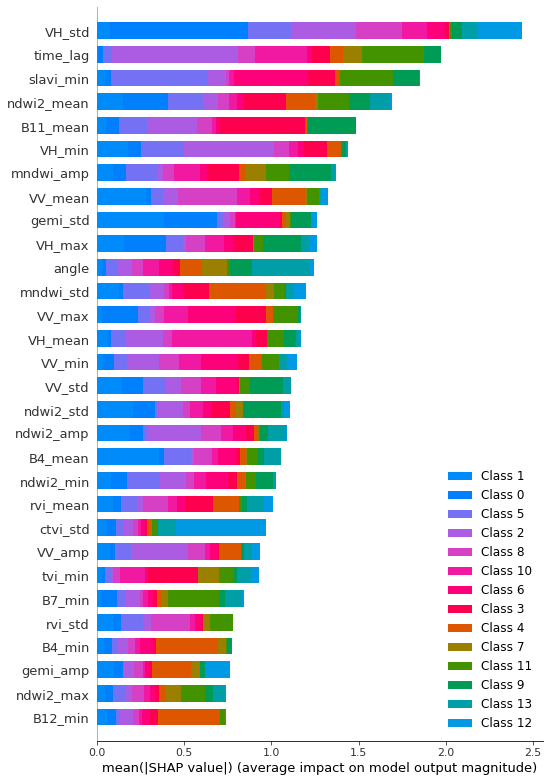

In [53]:
# Se visualizan las 30 variables más importantes a nivel global asignadas por este método
shap.summary_plot(shap_values, X_test, max_display=30)

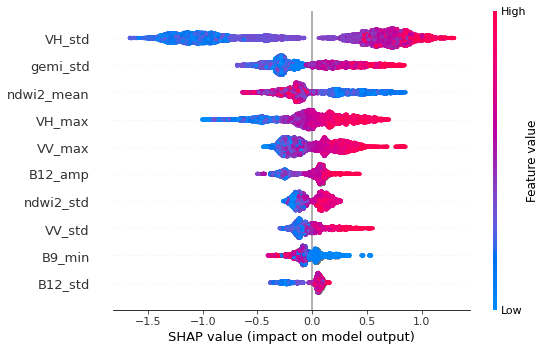

In [54]:
# Se visualizan las 10 variables que más influyen en las predicciones del cultivo de soja tipo 1 ('S')
shap.summary_plot(shap_values[0], X_test, max_display=10)

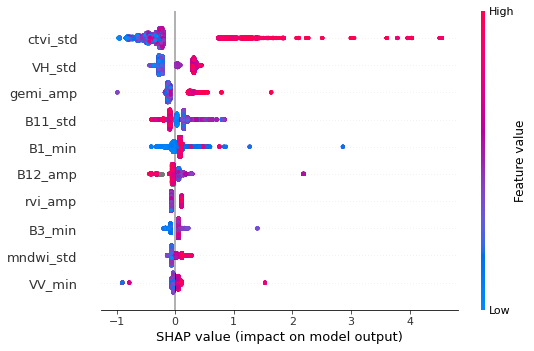

In [55]:
# Se imprimen las 10 variables más importantes que podrían ayudar a identificar el cultivo de girasol ('G')
shap.summary_plot(shap_values[12], X_test, max_display=10)

**La razón por la que se descargaron todas las imágenes de los satélites y se empleó un período de año a año (septiembre-agosto) para cada campaña es porque se pretendía generar variables que a través de la tendencia de los valores de las bandas o los índices ambientales le permitan reconocer al modelo por su cuenta los ciclos de los cultivos**. Por ejemplo, se pensó que una reducción repentina en el valor del *NDVI* de una semana a otra podría indicar la cosecha del cultivo. Si bien no se crearon variables de tendencia explícitamente como la pendiente de un polinomio de primer grado se esperaba que las 'features rodantes' aporten algo de información al modelo en ese sentido. 

**Los valores shapley sugieren que no son tan relevantes las variables rodantes agregadas (...roll_min', '...roll_max', etc.)**. Quedará pendiente revisar y profundizar los resultados obtenidos para ver si los datos de tendencias efectivamente son capaces de enriquecer un modelo de clasificación de cultivos. También, con estos resultados se debería evaluar si el ciclo anual elegido para cada campaña (septiembre-agosto) es el más apropiado.

Se seleccionan y analizan algunas de las variables indicadas como importantes para el `globalid` = 1 y el satélite *Landsat 8*.

In [56]:
# Selección de algunas variables importantes
train[(train["globalid"] == 1) & (train["satelite"] == 0)][
    [
        "globalid",
        "cultivo",
        "satelite",
        "time_lag",
        "VH_std",
        "slavi_mean",
        "ndwi2_mean",
        "VH_max",
        "VV_std",
    ]
].head(10)

,globalid,cultivo,satelite,time_lag,VH_std,slavi_mean,ndwi2_mean,VH_max,VV_std
0,1,0,0,343,0.015682,0.00566,0.001036,-0.038629,0.01146
1,1,0,0,343,0.015682,0.00566,0.001036,-0.038629,0.01146
2,1,0,0,343,0.015682,0.00566,0.001036,-0.038629,0.01146
3,1,0,0,343,0.015682,0.00566,0.001036,-0.038629,0.01146
4,1,0,0,343,0.015682,0.00566,0.001036,-0.038629,0.01146
5,1,0,0,343,0.015682,0.00566,0.001036,-0.038629,0.01146
6,1,0,0,343,0.015682,0.00566,0.001036,-0.038629,0.01146
7,1,0,0,343,0.015682,0.00566,0.001036,-0.038629,0.01146
8,1,0,0,343,0.015682,0.00566,0.001036,-0.038629,0.01146
9,1,0,0,343,0.015682,0.00566,0.001036,-0.038629,0.01146


Lo que se observa en la tabla anterior, según los valores de shapley, es que **los registros de las bandas de cada imagen e índices ambientales no influyen individualmente en las predicciones tanto como lo hacen todos ellos agrupados por** `globalid` **y** `satelite` manifestados en las medidas agregadas a través de ingeniería de características ('...mean', '...min', '...max', '...std' y '...amp').

Se decide aceptar lo devuelto por `shap_values` y **se avanza trabajando con las primeras 60 'variables importantes'** del dataset calculadas. Por lo tanto, como ya se adelantó, se puede simplificar la cantidad de registros por `globalid` en 3 observaciones (1 de *L8*, 1 de *S2-l2A* y 1 de *S2-l1C*).

In [57]:
# Agrupación de variables importantes
train[(train["globalid"] == 1)][
    [
        "globalid",
        "cultivo",
        "satelite",
        "time_lag",
        "VH_std",
        "slavi_mean",
        "ndwi2_mean",
        "VH_max",
        "VV_std",
    ]
].groupby(["globalid", "satelite"]).mean().reset_index()

,globalid,satelite,cultivo,time_lag,VH_std,slavi_mean,ndwi2_mean,VH_max,VV_std
0,1,0,0,343,0.015682,0.005660,0.001036,-0.038629,0.011460
1,1,1,0,350,0.016622,0.004450,0.000799,-0.035179,0.011091
2,1,2,0,238,0.028944,0.008339,0.000837,-0.051734,0.013778


En retrospectiva cabe preguntarse si con el criterio adoptado en el trabajo tiene sentido descargar de *GEE* la colección de imágenes completa o directamente convendría combinarlas mediante reducción (media, mediana) en una sola imagen (por satélite y nivel de corrección). 

Además, las agregaciones de grupo ('...min', '...mean', etc.) se calcularon en el período septiembre-agosto las cuales surgen como las variables más importantes para el modelo. **Debido a que finalmente no se emplean valores de tendencia, surge la inquietud si sería adecuado repensar el problema eligiendo otro intervalo de tiempo**, por ejemplo, diciembre-marzo dónde se espera que los valores de los índices ambientales sean mayores y así, tal vez, reducir el ruido en los datos y mejorar la clasificación. 

**Para el modelo final se confía en lo producido hasta el momento y se sigue adelante sin realizar cambios**.

## 5. Datos de entrada del modelo

### 5.1. Selección de variables
Del conjunto de datos se seleccionan algunas de las variables definidas como 'importantes'.

In [58]:
# Lista de variables importantes
model_vars = [
    "globalid",
    "cultivo",
    "satelite",
    "time_lag",
    "VH_std",
    "angle",
    "ndwi2_mean",
    "VH_max",
    "VV_std",
    "mndwi_std",
    "VV_mean",
    "VH_min",
    "VV_max",
    "gemi_std",
    "gemi_amp",
    "ndwi2_amp",
    "ndwi2_std",
    "VH_mean",
    "tvi_min",
    "slavi_min",
    "VV_min",
    "B4_mean",
    "B11_mean",
    "gemi_min",
    "mndwi_amp",
    "tvi_mean",
    "ctvi_min",
    "rvi_std",
    "B1_mean",
    "ctvi_mean",
    "rvi_mean",
    "ndwi2_min",
    "VH_amp",
    "B4_min",
    "slavi_mean",
    "slavi_std",
    "tvi_max",
    "tvi_std",
    "B5_mean",
    "ctvi_amp",
    "ndwi2_max",
    "B9_min",
    "gemi_mean",
    "B11_std",
    "rvi_min",
    "ctvi_std",
    "savi_mean",
    "B3_min",
    "mndwi_min",
    "B7_min",
    "savi_std",
    "B11_min",
    "B7_mean",
    "B12_amp",
    "B5_min",
    "B3_max",
    "rvi_max",
    "B8_min",
    "B1_min",
    "B3_amp",
    "B12_min",
    "rvi_amp",
    "B1_std",
]

In [59]:
# Se filtran las columnas importantes en train y test
train_var_select = train[[c for c in train.columns if c in model_vars]]
test_var_select = test[[c for c in train.columns if c in model_vars]]

train_var_select.shape

(93924, 63)

In [60]:
# Vista previa de train
train_var_select[train_var_select['globalid'] == 1].iloc[0:5, 0:14]

,globalid,cultivo,satelite,angle,time_lag,B1_mean,B1_min,B1_std,B3_min,B3_max,B3_amp,B4_mean,B4_min,B5_mean
0,1,0,0,41.442062,343,1.962497,0.370262,2.419895,1.304665,11.950437,10.645773,3.137689,0.715743,10.189438
1,1,0,0,35.690531,343,1.962497,0.370262,2.419895,1.304665,11.950437,10.645773,3.137689,0.715743,10.189438
2,1,0,0,35.691539,343,1.962497,0.370262,2.419895,1.304665,11.950437,10.645773,3.137689,0.715743,10.189438
3,1,0,0,NaN,343,1.962497,0.370262,2.419895,1.304665,11.950437,10.645773,3.137689,0.715743,10.189438
4,1,0,0,35.692444,343,1.962497,0.370262,2.419895,1.304665,11.950437,10.645773,3.137689,0.715743,10.189438


Se reducen los registros de cada `globalid` a 3 filas, 1 por satélite.

In [61]:
# Se agrupan los registros por 'globalid' y 'satelite' mediante el promedio
train_model = train_var_select.groupby(["globalid", "satelite"]).mean().reset_index()
test_model = test_var_select.groupby(["globalid", "satelite"]).mean().reset_index()

In [62]:
# Vista previa del 'globalid' 1 en train
train_model[train_model["globalid"] == 1].iloc[:, 0:14]

,globalid,satelite,cultivo,angle,time_lag,B1_mean,B1_min,B1_std,B3_min,B3_max,B3_amp,B4_mean,B4_min,B5_mean
0,1,0,0,36.013251,343,1.962497,0.370262,2.419895,1.304665,11.950437,10.645773,3.137689,0.715743,10.189438
1,1,1,0,35.215152,350,3.862335,3.030000,0.551112,1.842857,4.897143,3.054286,3.129877,0.981429,3.897773
2,1,2,0,34.975502,238,1.233660,0.004202,0.982246,1.138655,6.151261,5.012605,4.009004,0.336134,5.836668


In [63]:
# Vista previa del 'globalid' 2 en test
test_model[test_model["globalid"] == 2].iloc[:, 0:14]

,globalid,satelite,cultivo,angle,time_lag,B1_mean,B1_min,B1_std,B3_min,B3_max,B3_amp,B4_mean,B4_min,B5_mean
0,2,0,NaN,36.040569,343,2.412868,0.332362,2.726039,1.029155,11.469388,10.440233,3.798635,0.690962,8.769944
1,2,1,NaN,35.240862,350,4.340292,2.917143,2.797969,1.937143,18.848571,16.911429,3.513917,1.177143,4.147588
2,2,2,NaN,35.000753,238,1.202614,0.214286,0.727903,1.445378,5.899160,4.453782,4.232193,0.586134,5.928438


### 5.1. Se guardan los datos de entrada del modelo

In [64]:
# Train
pd.DataFrame.to_csv(
    train_model, os.path.join(MODEL_INPUT, "train_model_lgbm_02_141220.csv"), index=False
)

# Test
pd.DataFrame.to_csv(
    train_model, os.path.join(MODEL_INPUT, "test_model_lgbm_02_141220.csv"), index=False
)

In [65]:
train_model.shape

(4221, 63)

In [66]:
test_model.shape

(1665, 63)

## 6. Modelo de clasificación propuesto

### 6.1. Entrenamiento del modelo

Para la clasificación de los cultivos se elige un algoritmo de Gradient Boosting (*Lightgbm*). Se preparan los datos de entrenamiento y se ajusta el modelo propuesto.

In [67]:
# Se preparan los datos de train y test
X_train_model = train_model.drop(["globalid", "cultivo"], axis=1)
y_train_model = train_model[["cultivo"]]

X_test_model = test_model.drop(["globalid", "cultivo"], axis=1)

In [68]:
X_train_model.shape

(4221, 61)

In [69]:
X_test_model.shape

(1665, 61)

In [70]:
# Formato lightgbm
dtrain_model = lgb.Dataset(X_train_model, y_train_model)

# Parámetros elegidos para el modelo
# Mantener 'seed' = 124 y 'num_threads' = 4 para garantizar la reproducibilidad 
params_model = {
    "boosting_type": "goss",
    "objective": "multiclass",
    "num_class": 14,
    "boost_from_average": True,
    "feature_fraction": 0.3,
    "learning_rate": 0.065,
    "max_bin": 21,
    "min_data_in_leaf": 67,
    "min_gain_to_split": 0,
    "num_leaves": 379,
    "other_rate": 0.01,
    "top_rate": 0.5,
    "seed": 124,
    "num_threads": 4,
    "verbosity": -1,
}

# Entrenamiento
bst_model = lgb.train(params=params_model, train_set=dtrain_model, num_boost_round=1088)

# Se guarda el modelo
joblib.dump(bst_model, os.path.join(MODEL_OUTPUT,'lgbm_classifier_02_141220.pkl'))

# Se carga el modelo guardado
# bst_model = joblib.load(os.path.join(MODEL_OUTPUT,'lgbm_classifier_02_141220.pkl'))

['D:\\Proyectos\\DesafioAgTech2020\\resultado/lgbm_classifier_02_141220.pkl']

### 6.2. Clasificación de los cultivos
Con el modelo entrenado se realizan las predicciones de los registros del conjunto de evaluación.

In [71]:
# Predicciones sobre test
y_pred_model = bst_model.predict(X_test_model)

# Se agrega el 'globalid' correspondiente a las predicciones
df_pred = pd.concat([test_model["globalid"], pd.DataFrame(y_pred_model)], axis=1)

# Se agrupan sumando los valores de las probabilidades
df_pred = df_pred.groupby("globalid").sum()

# Se considera que la mayor probabilidad de cada registro define la clase de cultivo
y_pred_max = df_pred.idxmax(axis=1).reset_index()
y_pred_max.columns = ["globalid", "cultivo"]

In [72]:
# Vista d predia de las predicciones obtenidas
y_pred_max.head()

,globalid,cultivo
0,2,1
1,3,1
2,5,1
3,8,6
4,11,6


Los valores de las predicciones (números enteros) se remapean con los valores de `cultivoid` que les corresponden.

In [73]:
# Primero se remapea a la variable 'cultivo'
cultivo_id = {v: k for k, v in cultivo_num.items()}
cultivo_id

{0: 'S',
 1: 'M',
 2: 'U',
 3: 'B',
 4: 'R',
 5: 's',
 6: 'N',
 7: 'm',
 8: 'P',
 9: 'A',
 10: 'X',
 11: 'T',
 12: 'G',
 13: 'aa'}

In [74]:
# Vista previa de los cultivos predichos
y_pred_max = y_pred_max.replace({"cultivo": cultivo_id})
y_pred_max.head()

,globalid,cultivo
0,2,M
1,3,M
2,5,M
3,8,N
4,11,N


In [75]:
# Se agrega 'cultivoid' a train
submit = pd.merge(y_pred_max, df_etiquetas, on="cultivo", how="left")

# Se elimina lo que no se necesita
submit = submit.drop(["tipo", "cultivo",], axis=1)
submit.head()

,globalid,cultivoid
0,2,3
1,3,3
2,5,3
3,8,10
4,11,10


### 6.3. Submit

In [76]:
# Submit
pd.DataFrame.to_csv(
    submit, os.path.join(SUBMIT, "submit_lgbm_02_141220.csv"), header=False, index=False
)

## 7. Consideraciones finales  y conclusión

In [77]:
submit["cultivoid"].value_counts()

1     252
3     157
2      45
10     40
9      35
24     13
15      4
8       3
23      2
4       2
19      1
11      1
Name: cultivoid, dtype: int64

De las 14 clases existentes en el conjunto de entrenamiento el modelo designó un total de 12 en los registros de evaluación. **A partir de la solución provista en la competencia se puede comprobar que el dataset de testeo cuenta con 11 clases únicas**.

In [78]:
# Se carga el dataset de test con las soluciones
data_test_solucion = pd.read_csv(TEST_SOLUCION)

# Se renombra la columna 'Cultivo'
data_test_solucion.rename(columns={"Cultivo": "cultivo"}, inplace=True)

data_test_solucion.head()

,Id,cultivo,Longitud,Latitud,Elevacion,Dataset,Campania,Clase,GlobalId
0,2,M,-62.150971,-33.797816,104.111862,BC,18/19,NaN,2
1,3,M,-62.148934,-33.804243,105.698082,BC,18/19,NaN,3
2,5,M,-62.163801,-33.812363,104.233162,BC,18/19,NaN,5
3,8,N,-62.169497,-33.810439,103.859932,BC,18/19,NaN,8
4,11,N,-62.114892,-33.786731,101.769859,BC,18/19,NaN,11


In [79]:
# Cantidad y tipos de cultivo en test
data_test_solucion['cultivo'].value_counts()

S    229
M    140
s     58
N     54
P     36
X     22
U      7
R      3
B      3
m      2
A      1
Name: cultivo, dtype: int64

Se crea una matriz de confusión para evaluar la calidad del modelo final desarrollado.

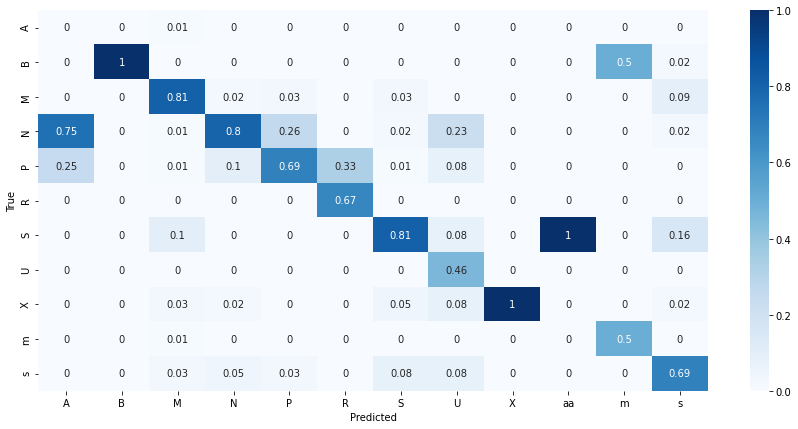

In [80]:
# Diccionario con las predicciones del modelo final y los valores reales
df_eval = {
    "y_pred": y_pred_max["cultivo"].values,
    "y_test": data_test_solucion["cultivo"].values,
}

# Se crea un dataframe con los valores predichos y los valores reales
df_eval = pd.DataFrame(df_eval, columns=["y_pred", "y_test"])

# Se crea una tabla cruzada para representar la matriz de confusión
conf_matrix = pd.crosstab(
    df_eval["y_test"], df_eval["y_pred"], rownames=["True"], colnames=["Predicted"], margins=False
)

# Se transforman los valores en porcentajes (coeficientes)
conf_matrix = conf_matrix / conf_matrix.sum(axis=0)
conf_matrix = round(conf_matrix, 2)

# Visualización de la matriz
plt.figure(figsize=(15, 7))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.show()

El modelo identificó un cultivo como alfalfa ('aa') que no existe en el dataset de evaluación y no pudo acertar el único registro de agua ('A') que hay. Además, tuvo mayores dificultades para clasificar los cultivos de maíz tardío (m) y las zonas urbanas (U). En los demás casos el desempeño mejoró alcanzando valores de hasta 80% de exactitud. 

Se calcula el desempeño final del modelo medido con la métrica establecida en la competencia.

In [81]:
# Métrica de control
balanced_accuracy_final = balanced_accuracy_score(df_eval["y_test"], df_eval["y_pred"])

print(f"Balanced Accuracy: {balanced_accuracy_final}")

Balanced Accuracy: 0.5494666663295429


y_pred contains classes not in y_true


Sobre el submit enviado se corrige la predicción que debió clasificarse como agua ('A') y se contrasta el cambio en la métrica usada.

In [82]:
# Se asigna la clase agua ('A') en las predicciones hechas donde corresponde según test
# Ahora la única clase agua existente va a estar bien predicha
df_eval["y_pred"][df_eval["y_test"] == "A"] = "A"

# Métrica de control
balanced_accuracy_mod = balanced_accuracy_score(df_eval["y_test"], df_eval["y_pred"])

print(f"Balanced Accuracy: {balanced_accuracy_mod}")

Balanced Accuracy: 0.6403757572386338


**Si se hubiera clasificado bien el único registro de agua ('A') que hay en el dataset de testeo se alcanzaría una mejora de más del 16 % en la métrica de precisión balanceada, así, queda en evidencia la necesidad de acertar las predicciones de las clases minoritarias**. Tal vez, en dichas categorías no sería tan grave predecir falsos positivos (si provienen de las clases mayoritarias) mientras todos los verdaderos positivos sean identificados.

En el trabajo se podría haber probado un submuestreo de los registros de clases mayoritarias para enfocarse en la calidad de las predicciones de las categorías con menos observaciones en la base de entrenamiento o, por otro lado, sobre estas últimas intentar generar más datos a partir de nuevos 'puntos' ubicados a distancias mayores de 60 m.

A lo mejor la estrategia de hacer un modelo diferente por cada satélite (3 en total)  hubiese permitido que los parámetros de cada modelo de Gradient Boosting se ajustaran mejor a determinadas clases y mediante un ensamble obtener un resultado más preciso.

Por supuesto, se podrían haber utilizado datos de otros satélites o diferentes colecciones, así como otros tipos de modelos supervisados o no supervisados.

**Finalmente, el modelo propuesto se posicionó dentro de los 10 de mayor rendimiento de clasificación, pero queda claro que el margen de mejora para resolver el desafío planteado es amplio**.

## Referencias

- Google Earth Engine platform: https://earthengine.google.com/
- Shap values library: https://github.com/slundberg/shap
- Integrating Earth Engine with Tensorflow 2 - U-NET: https://csaybar.github.io/blog/2019/05/30/eetf/
- Google Earth Engine python API examples: https://github.com/renelikestacos/Google-Earth-Engine-Python-Examples
- Land cover classification with eo-learn: https://medium.com/sentinel-hub/land-cover-classification-with-eo-learn-part-1-2471e8098195
- Indicadores ambientales, QuickIndex: https://github.com/sacridini/QuickIndex
- DesafiosAgtech, Webinar R, Yanina Bellini Saibene: https://www.youtube.com/watch?v=JADzBIypdyY&feature=youtu.be
- DesafiosAgtech, Webinar Python, Alfredo Campos: https://www.youtube.com/watch?v=Nz01C2VT1MI
- DesafiosAgtech, Webinar GEE, Santiago Banchero: https://www.youtube.com/watch?v=0owpGWnoaZs&feature=youtu.be
- DesafiosAgtech, Webinar AWS, Maximiliano Paz y Nicolás Larrandart: https://www.youtube.com/watch?v=ybEvraFKR5Y&t=245s
- DesafiosAgtech, Webinar ML, Pablo Roccatagliata: https://www.youtube.com/watch?v=76gPtbmcTrA&amp;feature=youtu.be